# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [1]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data

(5000, 30, 8)
data x shape: (5000, 30, 8)
data y shape: (5000, 30, 1)


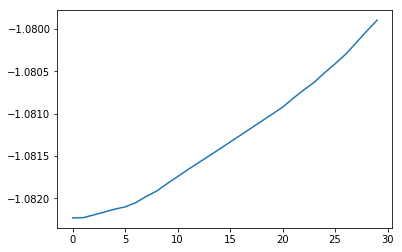

In [19]:
BATCH_SIZE=5000
TIME_SERIES_LENGTH = 30

def g1(x):
    return 1/(np.e * (x+0.023))

def g2(x):
    return -1/(x+0.02)

def g3(x):
    return 1/(x + 1.7)

def g4(x):
    return 3

def g5(x):
    return -1

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def create_data(batch_size=1000, time_series_length=500, moving_avg_n=1):
    funcs = [np.sin, np.cos, g1, g2, g3, g4, g5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, func_count + 1))
    y_data = np.zeros((batch_size, time_series_length, 1))
    y_prev = 0
    
    for batch_idx in range(batch_size):
        x = np.zeros((time_series_length, func_count+1), dtype=np.float16)
        y = np.zeros((time_series_length, 1))
        for t in range(time_series_length):
            selected_func_idx = np.random.randint(func_count)
            
            x[t, 0] = t/time_series_length
            x[t, selected_func_idx + 1] = 1
            
            y_pred = funcs[selected_func_idx](t)
            y[t, 0] = y_pred + (y_prev + 0.001)
            y_prev = y[t, 0]
            
        y = np.cumsum(y, axis=0)
        y[moving_avg_n:] = y[moving_avg_n:] - y[:moving_avg_n]
        y = y[moving_avg_n-1:] / moving_avg_n
                
        x_data[batch_idx, :] = x
        y_data[batch_idx, :] = y
      
    print(x_data.shape)    
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)

# Scaling
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)
plot(data_y[0])

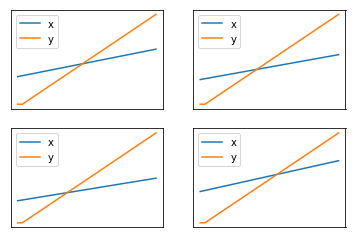

In [20]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
            sample_y = data_y[batch_idx]
                                    
            sample_x = sample_x[:, 0].reshape((-1, 1))
            
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x, label='x')
            sp.plot(tick_x, sample_y, label='y')
            sp.legend()

visualize(data_x, data_y)

## Model

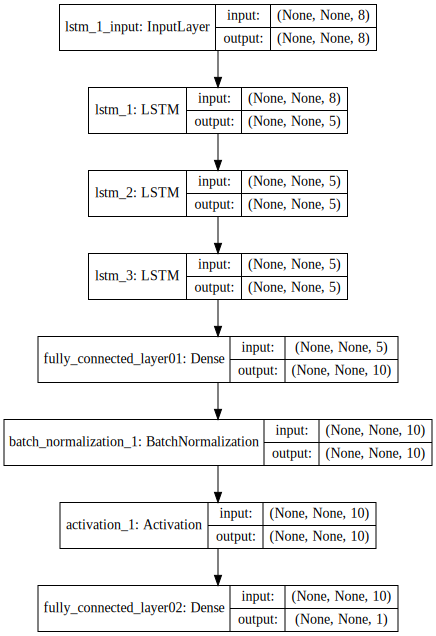

In [21]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, 8), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1, name='fully_connected_layer02'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Hyperparameter Optimization

In [ ]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return scoreepochs

# Grid Search 
params = dict(lstm_out1=[1, 4, 6, 10, 20, 50, 100], 
              lstm_out2=[None, 4, 6, 10, 20, 100], 
              lstm_out3=[None, 4, 6, 10, 20, 100], 
              optimizer=['adam'], 
              nb_epoch=[30, 200])

classifier = KerasRegressor(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer, n_jobs=1)
grid_result = grid.fit(X=data_x, y=data_y)

error:0.9311342615786549, score:0.07817997538455923
error:0.9163804572449392, score:0.07895236105238568
error:0.31095936531420015, score:0.6801578204652571
error:0.3107998050428667, score:0.6934531949317241
error:0.34206862551535344, score:0.663860378094901
error:0.3382513206735442, score:0.6587407854169831
error:0.8693935414821076, score:0.13930309636464433
error:0.8558105224767423, score:0.1398307822020276
error:0.36614872148160454, score:0.6233919342027032
error:0.36273071819238933, score:0.6422329069779764
error:0.21431603757455653, score:0.7893986572724221
error:0.20435610607659627, score:0.7938266608506478
error:1.880101080065185, score:-0.8612942251387726
error:1.8749547133368079, score:-0.8845039723397102
error:0.7633453886800038, score:0.21484901216429575
error:0.7635848848194091, score:0.24686404868390166
error:0.7523866886643324, score:0.26065427171803945
error:0.7433186157156981, score:0.2500714365905078
error:1.8072063181948788, score:-0.7891286374740059
error:1.8172515786

In [ ]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

## Training

In [9]:
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

Epoch 1/300
8s - loss: 0.4159 - mean_squared_error: 0.4159
Epoch 2/300
8s - loss: 0.2461 - mean_squared_error: 0.2461
Epoch 3/300
8s - loss: 0.1298 - mean_squared_error: 0.1298
Epoch 4/300
8s - loss: 0.1007 - mean_squared_error: 0.1007
Epoch 5/300
8s - loss: 0.0852 - mean_squared_error: 0.0852
Epoch 6/300
7s - loss: 0.0817 - mean_squared_error: 0.0817
Epoch 7/300
8s - loss: 0.0810 - mean_squared_error: 0.0810
Epoch 8/300
8s - loss: 0.0792 - mean_squared_error: 0.0792
Epoch 9/300
7s - loss: 0.0766 - mean_squared_error: 0.0766
Epoch 10/300
8s - loss: 0.0805 - mean_squared_error: 0.0805
Epoch 11/300
8s - loss: 0.0698 - mean_squared_error: 0.0698
Epoch 12/300
7s - loss: 0.0716 - mean_squared_error: 0.0716
Epoch 13/300
7s - loss: 0.0696 - mean_squared_error: 0.0696
Epoch 14/300
8s - loss: 0.0690 - mean_squared_error: 0.0690
Epoch 15/300
8s - loss: 0.0697 - mean_squared_error: 0.0697
Epoch 16/300
8s - loss: 0.0650 - mean_squared_error: 0.0650
Epoch 17/300
7s - loss: 0.0666 - mean_squared_err

error:0.01373816696803562, score:0.9862618330319642
score: 0.986261833032


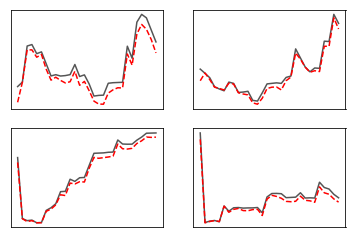

In [36]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red', linestyle='--')
            

visualize_prediction(data_x, data_y)

# Test

### test1

```
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

error:0.01373816696803562, score:0.9862618330319642
score: 0.986261833032
```